In [1]:
pip install nltk pillow torchvision torch tqdm


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import nltk
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from collections import defaultdict
from collections import Counter
nltk.download('punkt')  # for word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukehoward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
CAPTIONS_FILE = "Flickr8k_text/Flickr8k.token.txt"
IMAGES_FOLDER = "Flickr8k_Dataset"
FREQ_THRESHOLD = 5  # remove rare words

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized = self.tokenizer(text)
        return [
            self.stoi.get(token, self.stoi["<UNK>"])
            for token in tokenized
        ]

In [5]:
from PIL import UnidentifiedImageError
class Flickr8kDataset(Dataset):
    def __init__(self,captions_file,images_folder, transform=None, freq_threshold=5):
        self.captions_file = captions_file
        self.images_folder = images_folder
        self.transform = transform

        # Read the caption file
        self.image_captions = []
        with open(captions_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                img_id, caption = line.strip().split('\t')
                img_id = img_id.split('#')[0]
                img_id = img_id.split('#')[0]
                if not img_id.endswith('.jpg'):
                    img_id = img_id.split('.jpg')[0] + '.jpg'
                self.image_captions.append((img_id, caption))

        # Build vocab
        self.vocab = Vocabulary(freq_threshold)
        all_captions = [cap for _, cap in self.image_captions]
        self.vocab.build_vocab(all_captions)

    def __len__(self):
        return len(self.image_captions)
    
    def __getitem__(self, idx):
        img_id, caption = self.image_captions[idx]
        img_path = os.path.join(self.images_folder, img_id)

        try:
            # Try to open image
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"[ERROR] File not found: {img_path}")
        # Skip to another index (circular fallback)
            return self.__getitem__((idx + 1) % len(self.image_captions))
        except UnidentifiedImageError:
            print(f"[ERROR] Corrupted image or unsupported format: {img_path}")
            return self.__getitem__((idx + 1) % len(self.image_captions))

        if self.transform:
            image = self.transform(image)

        caption_tensor = torch.tensor([self.vocab.stoi["<SOS>"]] + 
                                  self.vocab.numericalize(caption) + 
                                  [self.vocab.stoi["<EOS>"]])

        return image, caption_tensor

In [6]:
import nltk
nltk.download("punkt_tab")
nltk.data.find("tokenizers/punkt_tab/english")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lukehoward/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


FileSystemPathPointer('/Users/lukehoward/nltk_data/tokenizers/punkt_tab/english')

In [7]:
from torch.utils.data import DataLoader

# Basic image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # scales to [0,1]
    transforms.Normalize((0.485, 0.456, 0.406),  # ImageNet mean
                         (0.229, 0.224, 0.225))  # ImageNet std
])

dataset = Flickr8kDataset(
    captions_file=CAPTIONS_FILE,
    images_folder=IMAGES_FOLDER,
    transform=transform,
    freq_threshold=FREQ_THRESHOLD
)

# View a sample
img, cap = dataset[0]
print("Image shape:", img.shape)
print("Caption token ids:", cap)
print("Decoded:", ' '.join([dataset.vocab.itos[i.item()] for i in cap]))


Image shape: torch.Size([3, 224, 224])
Caption token ids: tensor([ 1,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15,  3, 16,
        17,  2])
Decoded: <SOS> a child in a pink dress is climbing up a set of stairs in an <UNK> way . <EOS>


In [8]:
from torch.nn.utils.rnn import pad_sequence

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]  # Add batch dim to images
        images = torch.cat(images, dim=0)                  # Concatenate along batch dim
        captions = [item[1] for item in batch]
        captions = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions


In [9]:
from torch.utils.data import DataLoader

pad_idx = dataset.vocab.stoi["<PAD>"]  # Use your vocab pad token

loader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=Collate(pad_idx=pad_idx)
)


In [10]:
for images, captions in loader:
    print("Batch images shape:", images.shape)    # Expected: [32, 3, 224, 224]
    print("Batch captions shape:", captions.shape) # Expected: [32, max_caption_length_in_batch]
    break


Batch images shape: torch.Size([32, 3, 224, 224])
Batch captions shape: torch.Size([32, 24])


In [11]:
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove final FC layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Freeze all parameters (optional)
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.resnet(images)              # [batch, 2048, 1, 1]
        features = features.view(features.size(0), -1)  # [batch, 2048]
        features = self.fc(features)                    # [batch, embed_size]
        features = self.bn(features)
        return features


In [12]:
encoder = EncoderCNN(embed_size=256)
sample_images, _ = next(iter(loader))  # batch of 4
image_features = encoder(sample_images)  # [4, 256]
print(image_features.shape)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 256])


In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    def forward(self,features, captions):
        embeddings = self.embed(captions[:, :-1])
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)  # prepend image
        lstm_out, _ = self.lstm(embeddings)
        outputs = self.linear(self.dropout(lstm_out))
        return outputs



In [14]:
vocab_size = len(dataset.vocab)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=vocab_size)

sample_images, sample_captions = next(iter(loader))
features = encoder(sample_images)  # [32, 256]
outputs = decoder(features, sample_captions)  # [32, seq_len, vocab_size]

print(outputs.shape)

torch.Size([32, 25, 3005])


In [15]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EncoderCNN(embed_size=256).to(device)
decoder = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(dataset.vocab)).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters()), lr=3e-4)

In [16]:
num_epochs=1
for epoch in range(num_epochs):
    loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=Collate(pad_idx))
    loop = tqdm(loader, leave=True)

    for imgs, captions in loop:
        imgs, captions = imgs.to(device), captions.to(device)

        features = encoder(imgs)
        outputs = decoder(features, captions)

        # Shift target for loss
        targets = captions[:, 1:]  # skip <SOS>
        outputs = outputs[:, :-1, :]  # ignore output for final token

        # Flatten for loss: [batch*seq_len, vocab_size]
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

Epoch [1/1]:  12%|█▏        | 147/1265 [08:27<1:04:40,  3.47s/it, loss=4.86]

[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg


Epoch [1/1]:  25%|██▍       | 312/1265 [18:00<55:45,  3.51s/it, loss=4.64]  

[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg


Epoch [1/1]:  30%|███       | 381/1265 [22:02<51:46,  3.51s/it, loss=4.15]

[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg


Epoch [1/1]:  59%|█████▉    | 744/1265 [43:17<30:23,  3.50s/it, loss=4.35]

[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg


Epoch [1/1]:  86%|████████▌ | 1089/1265 [1:03:30<10:16,  3.50s/it, loss=3.85]

[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg
[ERROR] File not found: Flickr8k_Dataset/2258277193_586949ec62.jpg


Epoch [1/1]: 100%|██████████| 1265/1265 [1:13:46<00:00,  3.50s/it, loss=3.54]


In [17]:
torch.save({
        'encoder': encoder.state_dict(),
        'decoder': decoder.state_dict()
    }, f"model_epoch_{epoch+1}.pth")

In [24]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

def generate_caption_with_image(image_path, encoder, decoder, vocab, max_len=10):
    encoder.eval()
    decoder.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]

    # Encode image
    with torch.no_grad():
        features = encoder(image_tensor)

    # Start caption generation
    output = [vocab.stoi["<SOS>"]]
    state = None

    for _ in range(max_len):
        last_word = torch.tensor([output[-1]]).unsqueeze(0).to(device)  # [1, 1]
        embedding = decoder.embed(last_word)  # [1, 1, embed_size]

        if len(output) == 1:
            embedding = torch.cat((features.unsqueeze(1), embedding), dim=1)

        lstm_out, state = decoder.lstm(embedding, state)
        preds = decoder.linear(lstm_out[:, -1, :])
        next_word = preds.argmax(1).item()
        output.append(next_word)

        if next_word == vocab.stoi["<EOS>"]:
            break

    # Decode to words
    caption_words = [vocab.itos[idx] for idx in output]
    final_caption = ' '.join(caption_words[1:-1])  # Remove <SOS> and <EOS>

    # Show image and caption
    plt.imshow(image)
    plt.axis('off')
    plt.title(final_caption, fontsize=12)
    plt.show()

    return final_caption


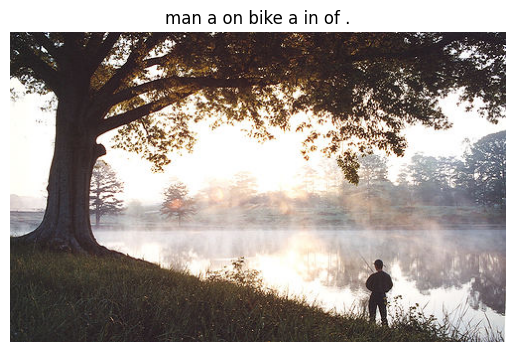

Caption: man a on bike a in of .


In [25]:
img_path = "Flickr8k_Dataset/17273391_55cfc7d3d4.jpg"
caption = generate_caption_with_image(img_path, encoder, decoder, dataset.vocab)
print("Caption:", caption)